# 短程-建立模型-最低價格_log

**線性模型**

In [5]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 對以下欄位進行 one-hot encoding（drop_first 用來避免共線性）
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵處理
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# ==========================================
# 選取建模時使用的特徵：
# 我們要使用與「出發時段」、「抵達時段」、「航空聯盟」、「機型分類」、「假期」、「Region」相關的 dummy 變數
# 以及數值特徵「飛行時間_分鐘」、「Cost of Living Index」、「GDP (PPP) per capita (in thousand USD)」
# ==========================================

# 找出所有欄位名稱中包含目標關鍵字的 dummy 變數
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '假期_', 'Region_']

dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]

# 最後的特徵欄位：dummy 變數 + 數值特徵
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 檢查選取的特徵
print("選取的特徵欄位:", feature_cols)

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格_log"]

# 分割數據集（訓練集與測試集）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 建立線性回歸模型
model = LinearRegression()
model.fit(X_train, y_train)

# 模型預測
y_pred = model.predict(X_test)

# 模型評估
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("測試集 MSE:", mse)
print("測試集 R^2:", r2)

# 產出模型公式
intercept = model.intercept_
coefficients = model.coef_
features = X.columns

formula = "平均價格_log = {:.3f}".format(intercept)
for coef, feat in zip(coefficients, features):
    formula += " + ({:.3f} * {})".format(coef, feat)
print("模型公式:")
print(formula)

選取的特徵欄位: ['出發時段_下午班機', '出發時段_凌晨班機', '出發時段_早晨班機', '出發時段_晚間班機', '抵達時段_下午抵達', '抵達時段_凌晨抵達', '抵達時段_早晨抵達', '抵達時段_晚間抵達', '航空聯盟_1', '航空聯盟_2', '航空聯盟_3', '航空聯盟_4', '機型分類_0', '機型分類_1', '機型分類_2', '假期_1', 'Region_日本', 'Region_泰國', 'Region_韓國', 'Region_香港', '飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
測試集 MSE: 0.09969367645969465
測試集 R^2: 0.6911939658994679
模型公式:
平均價格_log = -3221697069218.886 + (-0.085 * 出發時段_下午班機) + (-0.150 * 出發時段_凌晨班機) + (0.025 * 出發時段_早晨班機) + (-0.219 * 出發時段_晚間班機) + (0.014 * 抵達時段_下午抵達) + (0.084 * 抵達時段_凌晨抵達) + (-0.042 * 抵達時段_早晨抵達) + (0.084 * 抵達時段_晚間抵達) + (0.403 * 航空聯盟_1) + (0.360 * 航空聯盟_2) + (0.534 * 航空聯盟_3) + (-0.257 * 航空聯盟_4) + (-0.207 * 機型分類_0) + (-0.103 * 機型分類_1) + (-0.243 * 機型分類_2) + (0.168 * 假期_1) + (2659184940111.748 * Region_日本) + (3126669326073.921 * Region_泰國) + (3805797418188.642 * Region_韓國) + (4321690823985.237 * Region_香港) + (-0.047 * 飛行時間_分鐘) + (-1842851049554.248 * Cost of Living Index) + (2105389878820.841 * GDP (PPP) per capita (in t

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格_log"]

# 設定五組隨機種子
seeds = [123, 234, 345, 456, 567]
results = []

for seed in seeds:
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # 建立線性回歸模型
    model = LinearRegression()
    model.fit(X_train, y_train)

    # 預測
    y_pred = model.predict(X_test)

    # 評估
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 儲存結果
    results.append({'Seed': seed, 'MSE': mse, 'R^2': r2})

# 轉換為 DataFrame 並顯示
results_df = pd.DataFrame(results)
print(results_df)

   Seed       MSE       R^2
0   123  0.117739  0.637927
1   234  0.102777  0.683228
2   345  0.111028  0.654155
3   456  0.112420  0.654665
4   567  0.094517  0.703042


**隨機森林**

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格_log"]

# 設定五組隨機種子
seeds = [123, 234, 345, 456, 567]
results = []

for seed in seeds:
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # 建立隨機森林回歸模型
    model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)

    # 預測
    y_pred = model.predict(X_test)

    # 評估
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 儲存結果
    results.append({'Seed': seed, 'MSE': mse, 'R^2': r2})

# 轉換為 DataFrame 並顯示
results_df = pd.DataFrame(results)
print(results_df)

   Seed       MSE       R^2
0   123  0.111892  0.655908
1   234  0.100435  0.690448
2   345  0.111976  0.651203
3   456  0.107400  0.670086
4   567  0.087395  0.725417


**SVM**

In [3]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# 將「飛行時間」轉換為分鐘數
def convert_flight_time_to_minutes(time_str):
    if isinstance(time_str, str):  # 確保是字串才處理
        match = re.match(r'(\d+) 小時(?: (\d+) 分鐘)?', time_str)
        if match:
            hours = int(match.group(1))
            minutes = int(match.group(2)) if match.group(2) else 0
            return hours * 60 + minutes
    return None  # 如果不是字串或無法解析則返回 None

data['飛行時間_分鐘'] = data['飛行時間'].apply(convert_flight_time_to_minutes)

# 轉換日期格式
data['出發日期'] = pd.to_datetime(data['出發日期'])

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化（SVM 需要標準化）
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格_log"]

# 設定五組隨機種子
seeds = [123, 234, 345, 456, 567]
results = []

for seed in seeds:
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # 建立 SVR 模型
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # RBF 核函數
    model.fit(X_train, y_train)

    # 預測
    y_pred = model.predict(X_test)

    # 評估
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 儲存結果
    results.append({'Seed': seed, 'MSE': mse, 'R^2': r2})

# 轉換為 DataFrame 並顯示
results_df = pd.DataFrame(results)
print(results_df)

   Seed       MSE       R^2
0   123  0.096792  0.702345
1   234  0.081141  0.749913
2   345  0.089445  0.721387
3   456  0.089455  0.725208
4   567  0.073110  0.770299


**XGBoost**

In [4]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化（XGBoost **不一定** 需要標準化，但可以做）
num_cols = ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格_log"]

# 設定五組隨機種子
seeds = [123, 234, 345, 456, 567]
results = []

for seed in seeds:
    # 分割數據集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # 建立 XGBoost 模型
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)

    # 預測
    y_pred = model.predict(X_test)

    # 評估
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # 儲存結果
    results.append({'Seed': seed, 'MSE': mse, 'R^2': r2})

# 轉換為 DataFrame 並顯示
results_df = pd.DataFrame(results)
print(results_df)

   Seed       MSE       R^2
0   123  0.102516  0.684741
1   234  0.086314  0.733971
2   345  0.103043  0.679029
3   456  0.094183  0.710685
4   567  0.079006  0.751773


**30次平均**

In [6]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = '/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv'
data = pd.read_csv(file_path)

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號', '機場客運量分類', 
                    '航空公司', '航空聯盟', '是否過夜', '是否為平日', '機型', '機型分類', '艙等', '假期', 'Region']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 數值型特徵標準化
num_cols = ['飛行時間_分鐘', '最低價格剩餘天數', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_', '機場客運量分類_']
dummy_cols = [col for col in data.columns if any(keyword in col for keyword in target_keywords)]
feature_cols = dummy_cols + ['飛行時間_分鐘', '最低價格剩餘天數', 'Cost of Living Index', 'GDP (PPP) per capita (in thousand USD)']

# 定義自變數與目標變數
X = data[feature_cols]
y = data["最低價格_log"]

# 定義要跑的次數 (30 次)
n_runs = 30
seeds = list(range(n_runs))

# 用來儲存結果的字典
results = {
    'RandomForest': {'MSE': [], 'R2': []},
    'SVR': {'MSE': [], 'R2': []},
    'XGBoost': {'MSE': [], 'R2': []}
}

# 依序對每個隨機種子進行訓練與評估
for seed in seeds:
    # 分割數據集 (70% 訓練，30% 測試)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    # 隨機森林
    rf_model = RandomForestRegressor(n_estimators=200, random_state=seed, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    results['RandomForest']['MSE'].append(mse_rf)
    results['RandomForest']['R2'].append(r2_rf)
    
    # SVR
    svr_model = SVR()
    svr_model.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)
    results['SVR']['MSE'].append(mse_svr)
    results['SVR']['R2'].append(r2_svr)
    
    # XGBoost
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=seed, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    results['XGBoost']['MSE'].append(mse_xgb)
    results['XGBoost']['R2'].append(r2_xgb)

# 計算平均結果
avg_results = {}
for model_name, metrics in results.items():
    avg_mse = np.mean(metrics['MSE'])
    avg_r2 = np.mean(metrics['R2'])
    avg_results[model_name] = {'Average MSE': avg_mse, 'Average R2': avg_r2}

# 顯示結果
print("Average Performance over {} runs:".format(n_runs))
for model, scores in avg_results.items():
    print(f"{model}: MSE = {scores['Average MSE']:.4f}, R^2 = {scores['Average R2']:.4f}")

Average Performance over 30 runs:
RandomForest: MSE = 0.0719, R^2 = 0.7815
SVR: MSE = 0.0888, R^2 = 0.7306
XGBoost: MSE = 0.0598, R^2 = 0.8183


**視覺化**

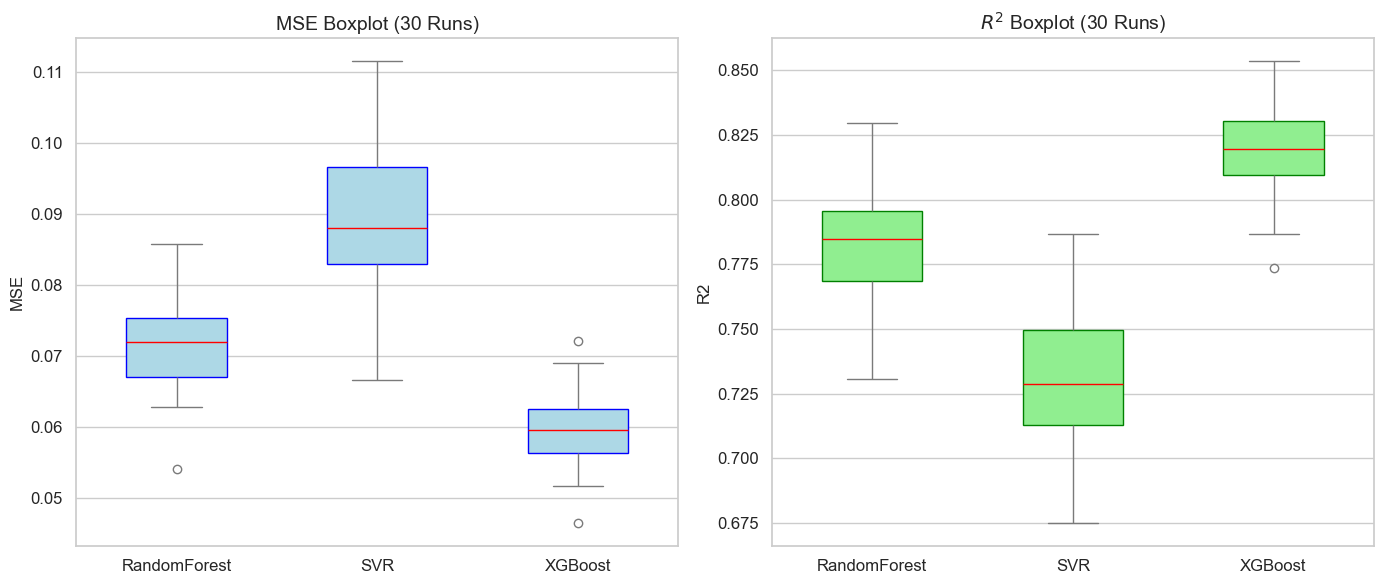

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 假設 results 字典已包含各模型 30 次的結果
# 轉換資料格式
mse_df = pd.DataFrame({
    'RandomForest': results['RandomForest']['MSE'],
    'SVR': results['SVR']['MSE'],
    'XGBoost': results['XGBoost']['MSE']
})
r2_df = pd.DataFrame({
    'RandomForest': results['RandomForest']['R2'],
    'SVR': results['SVR']['R2'],
    'XGBoost': results['XGBoost']['R2']
})

# 使用 melt 將資料轉為長格式 (long-form)
mse_long = mse_df.melt(var_name='Model', value_name='MSE')
r2_long = r2_df.melt(var_name='Model', value_name='R2')

# 設定 Seaborn 主題
sns.set(style='whitegrid', palette='pastel')

# 建立圖形
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MSE 盒鬚圖
sns.boxplot(x='Model', y='MSE', data=mse_long, ax=axes[0],
            width=0.5, showfliers=True, 
            boxprops={'facecolor':'lightblue', 'edgecolor':'blue'},
            medianprops={'color': 'red'})
axes[0].set_title('MSE Boxplot (30 Runs)', fontsize=14)
axes[0].set_xlabel('')
axes[0].tick_params(labelsize=12)

# R^2 盒鬚圖
sns.boxplot(x='Model', y='R2', data=r2_long, ax=axes[1],
            width=0.5, showfliers=True,
            boxprops={'facecolor':'lightgreen', 'edgecolor':'green'},
            medianprops={'color': 'red'})
axes[1].set_title('$R^2$ Boxplot (30 Runs)', fontsize=14)
axes[1].set_xlabel('')
axes[1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()